The predicted caption: 
startseq man in yellow kayak is paddling through the water endseq


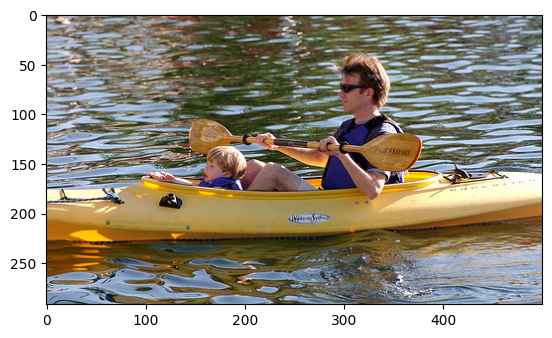

In [16]:
import os
import pickle
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from PIL import Image

# Set base directories
BASE_DIR = '/kaggle/input/flickr8k'  # Updated to your new image directory
WORKING_DIR = '/kaggle/working'

# Load the trained model
def load_trained_model(model_path='/kaggle/input/imagecaptioning/best_model.keras'):
    return load_model(model_path)

# Load features from pickle
def load_features_from_pickle(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

# Load tokenizer from pickle
def load_tokenizer_from_pickle(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

# Generate caption for an image
def generate_caption(image_name, model, tokenizer, max_length, features):
    # Extract the image ID by removing the file extension
    image_id = image_name.split('.')[0]
    # Predict the caption for the image
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    # Print the predicted caption to the console
    print('The predicted caption: ')
    print(y_pred)
    # Display the image from the new directory
    img_path = os.path.join(BASE_DIR, "Images", image_name)  # Updated path
    image = Image.open(img_path)
    plt.imshow(image)
    plt.show()

# Predict the caption from the model
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length, padding='post')
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break
    return in_text

# Convert index to word
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# Main execution function
def main():
    # Load the trained model
    model = load_trained_model(model_path='/kaggle/input/imagecaptioning/best_model.keras')
    
    # Load features and tokenizer
    features = load_features_from_pickle('/kaggle/input/imagecaptioning/features.pkl')
    tokenizer = load_tokenizer_from_pickle('/kaggle/input/imagecaptioning/tokenizer.pkl')
    
    # Set max_length to 35 (corrected value)
    max_length = 35  # Set to the value from your training session (adjust as needed)
    
    # Generate caption for an image (replace with the actual image name)
    generate_caption("1028205764_7e8df9a2ea.jpg", model, tokenizer, max_length, features)

if __name__ == "__main__":
    main()


The predicted caption: 
startseq man riding bike in the street endseq


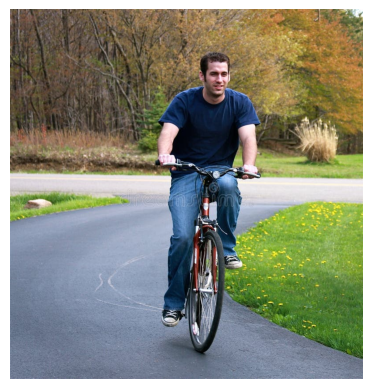

In [17]:
import os
import pickle
import numpy as np
import requests
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image
import matplotlib.pyplot as plt
from io import BytesIO

# Set up directories and paths
BASE_DIR = '/kaggle/input/flickr8k'  # Base directory for the Flickr8k dataset
WORKING_DIR = '/kaggle/working'  # Working directory for intermediate outputs

# Load the trained model
def load_trained_model(model_path='/kaggle/input/imagecaptioning/best_model.keras'):
    """Loads and returns the trained model from the given path."""
    return load_model(model_path)

# Load features from pickle file
def load_features_from_pickle(filename):
    """Loads the features (extracted from images) from a pickle file."""
    with open(filename, 'rb') as f:
        return pickle.load(f)

# Load tokenizer from pickle file
def load_tokenizer_from_pickle(filename):
    """Loads the tokenizer (for text processing) from a pickle file."""
    with open(filename, 'rb') as f:
        return pickle.load(f)

# Load and preprocess image from URL or local path
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    """Loads an image from the URL or local path and preprocesses it for VGG16."""
    # Check if the image_path is a URL or a local file
    if image_path.startswith('http'):
        # If it's a URL, download the image
        response = requests.get(image_path)
        img = Image.open(BytesIO(response.content))
    else:
        # Otherwise, load from local path
        img = Image.open(image_path)
    
    # Resize the image using LANCZOS filter to target size
    img = img.resize(target_size, Image.Resampling.LANCZOS)
    
    # Convert image to numpy array and preprocess it for VGG16 model
    img_array = img_to_array(img)
    img_array = img_array.reshape((1, img_array.shape[0], img_array.shape[1], img_array.shape[2]))
    img_array = preprocess_input(img_array)
    
    return img_array  # Return the preprocessed image array

# Convert index to word using the tokenizer
def idx_to_word(integer, tokenizer):
    """Converts an index to the corresponding word using the tokenizer."""
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# Generate caption using the trained model
def predict_caption(model, feature, tokenizer, max_length):
    """Generates a caption for the image feature using the trained model."""
    in_text = 'startseq'  # Start the sequence with 'startseq'
    for i in range(max_length):
        # Convert the input text to sequence of integers
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # Pad the sequence to the fixed length
        sequence = pad_sequences([sequence], max_length, padding='post')
        # Predict the next word in the sequence
        yhat = model.predict([feature, sequence], verbose=0)
        yhat = np.argmax(yhat)  # Get the word with the highest probability
        word = idx_to_word(yhat, tokenizer)  # Convert index to word
        if word is None:
            break  # If no word is found, break the loop
        in_text += " " + word  # Add the predicted word to the sequence
        if word == 'endseq':
            break  # Stop if the end of the sequence is reached
    return in_text

# Generate caption for an image (with explicit predict_caption)
def generate_caption(image_path, model, tokenizer, max_length, features):
    """Generates and displays a caption for an image."""
    # Load and preprocess the image
    image = load_and_preprocess_image(image_path)
    
    # Extract features from the image using the VGG16 model
    vgg_model = VGG16()  # Initialize the VGG16 model
    vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)  # Remove top layers
    feature = vgg_model.predict(image, verbose=0)  # Predict features for the image
    
    # Generate the caption using the trained model
    caption = predict_caption(model, feature, tokenizer, max_length)
    
    # Display the predicted caption
    print('The predicted caption: ')
    print(caption)
    
    # Since image is already loaded in load_and_preprocess_image, we just display it
    if image_path.startswith('http'):
        # If the image is a URL, download and open it
        response = requests.get(image_path)
        img = Image.open(BytesIO(response.content))
    else:
        # Otherwise, open the image from the local path
        img = Image.open(image_path)
    
    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.show()

# Main execution function
def main():
    """Main function to load the model, tokenizer, features and generate caption for an image."""
    # Load the trained model, features, and tokenizer
    model = load_trained_model(model_path='/kaggle/input/imagecaptioning/best_model.keras')
    features = load_features_from_pickle('/kaggle/input/imagecaptioning/features.pkl')
    tokenizer = load_tokenizer_from_pickle('/kaggle/input/imagecaptioning/tokenizer.pkl')
    
    # Set max_length to 35 (the value used during training)
    max_length = 35
    
    # Example usage: Replace with the actual image URL
    image_path = 'https://thumbs.dreamstime.com/b/man-riding-bicycle-14075246.jpg'  # Example image URL
    generate_caption(image_path, model, tokenizer, max_length, features)

# Run the main function
if __name__ == "__main__":
    main()
